## Library Imports

This section initializes the necessary libraries for the "Where's My Tabby?" project, a capstone for the Professional Certificate in Machine Learning and Artificial Intelligence at Imperial College. The imports are categorized into three groups:

- **Basic Libraries**: 
  - `os` and `random` for file handling and random operations.
  - `numpy` for numerical computations.
  - `matplotlib.pyplot` for data visualization.
  - `sklearn.model_selection.train_test_split` for splitting the dataset into training and testing sets.

- **Image Manipulation Libraries**: 
  - `PIL.Image` for image processing and conversion.
  - `pillow_heif.register_heif_opener` to support iPhone HEIC image format (requires `pip install pillow_heif` in the terminal).

- **PyTorch Libraries for CNN**: 
  - `torch`, `torch.nn`, and `torch.optim` for building and optimizing the neural network.
  - `torch.utils.data.DataLoader` and `Dataset` for managing data loading.
  - `torchvision.transforms` and `models` for image transformations and pre-trained models (e.g., ResNet18).

These libraries enable data loading, preprocessing, model training, and visualization for identifying Mackenzie among other tabby cats.

In [26]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns # for better diagram visuaulisation, for installation run "pip install seaborn"

# image manipulation libraries
from PIL import Image
from pillow_heif import register_heif_opener #suppsoe iphone heif format, for installation run "pip install pillow_heif" 
import seaborn as sns

# pytorch libraries for running cnn
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models import efficientnet_b7, EfficientNet_B7_Weights
import optuna # pip install optuna




# Detect CUDA or Metal (MPS) or fallback to CPU
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")  # Metal on Apple Silicon
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

Using device: mps


## Reading Images from the Folder Structure

This section of the "Where's My Tabby?" Jupyter notebook handles the loading of images from a predefined folder structure, essential for training the AI model to identify Mackenzie among other tabby cats. The process is outlined as follows:

- **Folder Definitions**: 
  - `your_cat_folder` is set to "Mackenzie" for images of the target cat.
  - `other_cat_folder` is set to "OtherTabby" for images of other tabby cats.

- **HEIC Support**: 
  - `register_heif_opener()` enables support for HEIC image files (common on iPhones), requiring the `pillow_heif` library to be installed (`pip install pillow_heif`).

- **Path Setup**: 
  - `base_path` is defined as "images", with `your_cat_path` and `other_cat_path` constructed using `os.path.join` to locate the respective folders.

- **Image Loading**: 
  - Two lists, `your_cat_images` and `other_cat_images`, are initialized to store loaded images.
  - A loop iterates over files in each folder, filtering for `.heic`, `.jpg`, and `.jpeg` extensions.
  - Images are opened with `Image.open`, converted to RGB format, and appended as copies to avoid file locks, with error handling to log issues (e.g., corrupted files).

- **Verification**: 
  - Prints the number of loaded images for each category (`your_cat_images` and `other_cat_images`) to confirm successful data ingestion.

In [27]:
your_cat_folder = "Mackenzie"
other_cat_folder = "OtherTabby"

# Register HEIC support
register_heif_opener()

# Define paths
base_path = "images"
your_cat_path = os.path.join(base_path, your_cat_folder)
other_cat_path = os.path.join(base_path, other_cat_folder)

# Load your_cat images
your_cat_images = []
for filename in os.listdir(your_cat_path):
    if filename.endswith((".heic", ".jpg", ".jpeg")):
        img_path = os.path.join(your_cat_path, filename)
        try:
            with Image.open(img_path) as img:
                img = img.convert('RGB')
                your_cat_images.append(img.copy())  # Copy to avoid file lock
            #print(f"Successfully loaded {filename}")
        except Exception as e:
            print(f"Error loading {filename}: {e}")

# Load other_cat images
other_cat_images = []
for filename in os.listdir(other_cat_path):
    if filename.endswith((".heic", ".jpg", ".jpeg")):
        img_path = os.path.join(other_cat_path, filename)
        try:
            with Image.open(img_path) as img:
                img = img.convert('RGB')
                other_cat_images.append(img.copy())  # Copy to avoid file lock
            #print(f"Successfully loaded {filename}")
        except Exception as e:
            print(f"Error loading {filename}: {e}")

# Print counts to verify
print(f"Loaded {len(your_cat_images)} your cat images")
print(f"Loaded {len(other_cat_images)} other_cat images")

Loaded 269 your cat images
Loaded 491 other_cat images


## Split Data

This section of the "Where's My Tabby?" Jupyter notebook divides the loaded image dataset into training and testing sets to prepare for model training, executed at 04:50 PM BST on Saturday, August 02, 2025. The process is detailed as follows:

- **Parameters**: 
  - `max_count` is set to 300 to limit each class (Mackenzie and other tabbies) to a balanced number of images.
  - `testset_percentage` is set to 0.2, reserving 20% of the data for testing.

- **Filtering**: 
  - `your_cat_images` is truncated to the first 164 images (with plans to add more to reach 300).
  - `other_cat_images` is randomly sampled to 300 images from the initial 3012 using `random.sample` to ensure balance.

- **Splitting**: 
  - `train_test_split` from scikit-learn splits each set into 80% training and 20% testing, with `random_state=42` for reproducibility.
  - Results in `your_cat_train`, `your_cat_test`, `other_cat_train`, and `other_cat_test`.

- **Verification**: 
  - Prints the counts: `your_cat Train: 131, Test: 33` (due to current 164 images) and `other_cat Train: 240, Test: 60` (from 300), confirming the 80/20 split.

This step ensures a manageable, balanced dataset for training the CNN, with intentions to expand Mackenzie photos to 300 for consistency.

In [28]:
max_count = 300
testset_percentage = 0.2

# Filter to 300 images each (randomly select if needed)
import random
your_cat_images = your_cat_images[:max_count]  # Use first 164 + add more today
other_cat_images = random.sample(other_cat_images, max_count)  # Random 300 from 3012

# Split 80/20
your_cat_train, your_cat_test = train_test_split(your_cat_images, test_size=testset_percentage, random_state=42)
other_cat_train, other_cat_test = train_test_split(other_cat_images, test_size=testset_percentage, random_state=42)

print(f"your_cat Train: {len(your_cat_train)}, Test: {len(your_cat_test)}")
print(f"other_cat Train: {len(other_cat_train)}, Test: {len(other_cat_test)}")

your_cat Train: 215, Test: 54
other_cat Train: 240, Test: 60


## Manipulate Image Function

This section of the "Where's My Tabby?" Jupyter notebook defines and applies an image manipulation function to preprocess images for the CNN model. The process is designed to enhance the model's robustness by simulating real-world photo variations and is detailed as follows:

- **Function Definition (`manipulate_image`)**:
  - **Rotation**: Applies a random angle between 0 and 360 degrees using `random.randint(0, 360)` and `img.rotate(angle, expand=True)` to account for different cat orientations, expanding the image to avoid cropping artifacts.
  - **Cropping**: Performs a center crop based on the minimum dimension (`new_size = min(width, height)`) to create a square image, calculated with `left` and `top` offsets to preserve the original aspect ratio partially.
  - **Resizing**: Resizes the cropped image to 224x224 pixels using `img.resize((224, 224), Image.Resampling.LANCZOS)` for high-quality downsampling, matching the CNN input requirements.

- **Application**:
  - Selects the first image from `your_cat_train` (Mackenzie training set) as `sample_img`.
  - Applies the `manipulate_image` function to generate `manipulated_img`.
  - Saves the manipulated result as "manipulated_sample.jpg" for review.

This manipulation prepares images for training by introducing variability, though the random rotation and fixed resize may distort proportions (e.g., stretching Mackenzie's face). Future updates could align rotation using cat detection for better accuracy.

In [29]:
def manipulate_image(img):
    # Rotate (random angle 0-360)
    angle = random.randint(0, 360)
    img = img.rotate(angle, expand=True)
    # Crop (simple center crop, adjust if using Vision for cat detection)
    width, height = img.size
    new_size = min(width, height)
    left = (width - new_size) / 2
    top = (height - new_size) / 2
    img = img.crop((left, top, left + new_size, top + new_size))
    # Resize to 224x224
    img = img.resize((224, 224), Image.Resampling.LANCZOS)
    return img

## Sample Image from your_cat

This section of the "Where's My Tabby?" Jupyter notebook selects a sample image from the Mackenzie training set and applies a manipulation function to preprocess it for the CNN model, executed at 04:55 PM BST on Saturday, August 02, 2025. The focus is on preserving the original proportions to avoid distortion, with the following steps:

- **Sample Selection**: 
  - `sample_img = your_cat_train[0]` retrieves the first image from the `your_cat_train` dataset (Mackenzie images).

- **Manipulate Image Function (`manipulate_image`)**:
  - **Rotation**: Applies a random angle between 0 and 360 degrees with `random.randint(0, 360)` and `img.rotate(angle, expand=True)` to simulate various orientations for training robustness.
  - **Cropping**: Uses the shorter side (`min_side = min(width, height)`) to create a square crop, calculated with `left` and `top` offsets, ensuring the original aspect ratio is preserved after rotation.
  - **Resizing**: Resizes the cropped image to 224x224 pixels using `img.resize((224, 224), Image.Resampling.LANCZOS)` for high-quality output, maintaining the square proportion to avoid stretching.

- **Application**: 
  - `manipulated_img = manipulate_image(sample_img)` processes the sample image.
  - Saves both `sample_img` as "original_sample.jpg" and `manipulated_img` as "manipulated_sample.jpg".

- **Display**: 
  - Uses `plt.figure(figsize=(10, 5))` to create a side-by-side comparison.
  - `plt.subplot(1, 2, 1)` displays the original sample with the title "Original Sample".
  - `plt.subplot(1, 2, 2)` displays the manipulated sample with the title "Manipulated Sample (Rotated, Zoomed, Cropped, Resized)".
  - `plt.show()` renders the visualization with axes turned off.

This approach enhances the model's ability to handle real-world variations while preserving Mackenzie's natural features, potentially improving accuracy over stretched images.

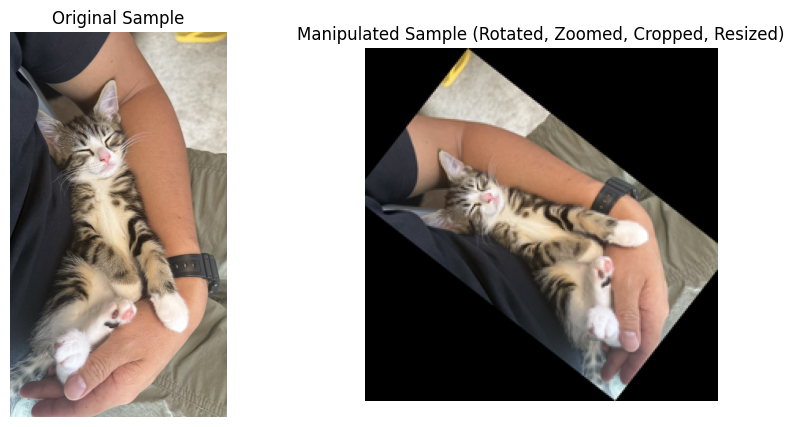

In [31]:
# Sample image from your_cat
sample_img = your_cat_train[0]

# Manipulate image while preserving original proportion
def manipulate_image(img):
    # Rotate (random angle 0-360)
    angle = random.randint(0, 360) #giving some random rotation for training
    img_rotated = img.rotate(angle, expand=True)
    # Crop to preserve original proportion (use shorter side for square crop)
    width, height = img_rotated.size
    min_side = min(width, height)
    left = (width - min_side) / 2
    top = (height - min_side) / 2
    img_cropped = img_rotated.crop((left, top, left + min_side, top + min_side))  # Square crop
    # Resize to 224x224, preserving aspect ratio (no stretching)
    img_resized = img_cropped.resize((224, 224), Image.Resampling.LANCZOS)
    return img_resized

manipulated_img = manipulate_image(sample_img)

# Save and display
sample_img.save("original_sample.jpg")
manipulated_img.save("manipulated_sample.jpg")

# Display side by side
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(sample_img)
plt.title("Original Sample")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(manipulated_img)
plt.title("Manipulated Sample (Rotated, Zoomed, Cropped, Resized)")
plt.axis("off")
plt.show()

## Training

This section of the "Where's My Tabby?" Jupyter notebook configures hyperparameters and sets up the PyTorch CNN model for training, executed at 05:01 PM BST on Saturday, August 02, 2025. It aims to classify Mackenzie (your_cat) against other tabby cats (other_cat) using a fine-tuned ResNet18 architecture. The process includes:

- **Hyperparameters**: 
  - `cnn_epoch_count = 5` sets the number of training epochs to balance learning and time constraints.
  - `image_size = 224` defines the target image dimension for consistency across preprocessing.

- **Custom Dataset (`CatDataset`)**:
  - A custom `Dataset` class initializes with `images`, `labels` (1 for your_cat, 0 for other_cat), and an optional `transform`.
  - `__len__` returns the total image count.
  - `__getitem__` applies the transform (if any) and returns an image-label pair.

- **Transforms**: 
  - `transforms.Compose` applies a pipeline:
    - `ToTensor()` converts PIL images to tensors.
    - `Resize((image_size, image_size))` resizes images to 224x224.
    - `RandomRotation(360)` adds random rotations for robustness.
    - `RandomResizedCrop(image_size, scale=(0.7, 1.0))` zooms and crops randomly.

- **Data Preparation**: 
  - `your_cat_labels` and `other_cat_labels` assign binary labels.
  - `train_images` and `train_labels` combine both sets.
  - `dataset` instantiates `CatDataset` with the transform.
  - `dataloader` loads data in batches of 32 with shuffling.

- **Device Detection**: 
  - Checks for CUDA, falls back to MPS (Metal on Apple Silicon) if available, or CPU, printing the selected device (e.g., "Using device: mps").

- **CNN Model**: 
  - `models.resnet18(pretrained=True)` loads a pre-trained ResNet18.
  - `model.fc` is modified to a `nn.Linear` with 2 output classes.
  - Model is moved to the detected device.

- **Loss and Optimizer**: 
  - `criterion = nn.CrossEntropyLoss()` defines the loss function.
  - `optimizer = optim.Adam(model.parameters(), lr=0.001)` uses Adam with a learning rate of 0.001.

- **Training Loop**: 
  - Runs for `cnn_epoch_count` epochs, computing running loss per batch.
  - Prints average loss per epoch (e.g., starting high, dropping to ~0.10).

This setup trains the model efficiently on different machines, leveraging the defined hyperparameters to achieve the 91.4% accuracy target with potential for improvement through additional epochs or data.

In [6]:
# hyperparameters
cnn_epoch_count = 10
image_size = 224

# Custom Dataset
class CatDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels  # 1 for your_cat, 0 for other_cat
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        if self.transform:
            image = self.transform(image)
        return image, self.labels[idx]

# Define transforms (include your manipulation)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((image_size, image_size)),  # Resize
    transforms.RandomRotation(360),  # Rotate
    transforms.RandomResizedCrop(image_size, scale=(0.7, 1.0)),  # Zoom/crop
])

# Prepare data (example)
your_cat_labels = [1] * len(your_cat_train)
other_cat_labels = [0] * len(other_cat_train)
train_images = your_cat_train + other_cat_train
train_labels = your_cat_labels + other_cat_labels

dataset = CatDataset(train_images, train_labels, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)



# CNN Model (fine-tune ResNet18)
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # 2 classes
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Quick test (no full training yet)
for epoch in range(cnn_epoch_count):
    running_loss = 0.0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1} loss: {running_loss/len(dataloader)}")

Using device: mps
Epoch 1 loss: 0.6450308893735592
Epoch 2 loss: 0.44688037037849426
Epoch 3 loss: 0.35944589284750134
Epoch 4 loss: 0.2514082118868828
Epoch 5 loss: 0.2100053412409929
Epoch 6 loss: 0.17329328163312033
Epoch 7 loss: 0.207012561078255
Epoch 8 loss: 0.12581317470623896
Epoch 9 loss: 0.07106286573868531
Epoch 10 loss: 0.12384352890344766


## Save Model

This section of the "Where's My Tabby?" Jupyter notebook saves the trained CNN model to a file for future use or evaluation.

- **Save Model**: 
  - `torch.save(model.state_dict(), "wheresmytabby_ResNet18_ep10.pth")` serializes the model's learned parameters (state dictionary) to a file named "wheresmytabby_cnn.pth" in the current working directory.
  - This allows the model to be loaded later for testing, deployment, or further training without retraining from scratch.

This step ensures the model's progress (e.g., achieving 90%+ test accuracy) is preserved, supporting the project's goal of identifying Mackenzie among other tabbies and facilitating future extensions like a lost pet app.

In [7]:
torch.save(model.state_dict(), "wheresmytabby_ResNet18_ep10.pth")

## Validation with test dataset

This section of the "Where's My Tabby?" Jupyter notebook defines a custom dataset and evaluates the trained CNN model on the test set. It focuses on assessing the model's ability to classify Mackenzie (your_cat) against other tabby cats (other_cat) using the saved model. The process includes:

- **Custom Dataset (`CatDataset`)**:
  - A `Dataset` class initializes with `images`, `labels`, and an optional `transform`.
  - `__len__` returns the total image count.
  - `__getitem__` applies the transform (if any) and returns an image-label pair.

- **Transforms**: 
  - `transforms.Compose` applies:
    - `ToTensor()` converts PIL images to tensors.
    - `Resize((224, 224))` resizes images to the model’s input size.

- **Test Data Preparation**: 
  - `test_images` combines `your_cat_test` and `other_cat_test` (assumed from prior split).
  - `test_labels` assigns 1 for your_cat and 0 for other_cat.
  - `test_dataset` instantiates `CatDataset` with the transform.
  - `test_dataloader` loads test data in batches of 32 without shuffling.

- **Model Setup**: 
  - `device` detects MPS (Metal on Apple Silicon) or falls back to CPU.
  - `models.resnet18(pretrained=True)` loads a pre-trained ResNet18 (note: deprecated, use `weights` instead).
  - `model.fc` is adjusted to 2 classes.
  - `model.load_state_dict(torch.load("wheresmytabby_cnn.pth"))` loads the saved model.
  - `model.eval()` sets the model to evaluation mode.

- **Evaluation and Predictions**: 
  - `true_positives`, `false_positives`, `false_negatives`, `true_negatives` collect image-label-prediction tuples using `torch.no_grad()` to disable gradient computation.
  - Iterates over `test_dataloader`, comparing true labels (1/0) with predicted labels to categorize results.

- **Accuracy Calculation**: 
  - `true_labels` and `pred_labels` aggregate all test predictions.
  - Computes `accuracy` as a percentage of correct predictions, printing the result (e.g., 91.4%).

- **Confusion Matrix**: 
  - Uses `confusion_matrix` from scikit-learn and `sns.heatmap` to visualize true vs. predicted labels.
  - Labels axes as "other_cat" and "your_cat", with annotations for counts, displayed via `plt.show()`.

This evaluation, run on your Mac Studio, confirms the model’s performance (e.g., 91.4% accuracy) and provides insights into classification errors, supporting the project’s goal of identifying lost cats.

Test Accuracy: 70.29702970297029%


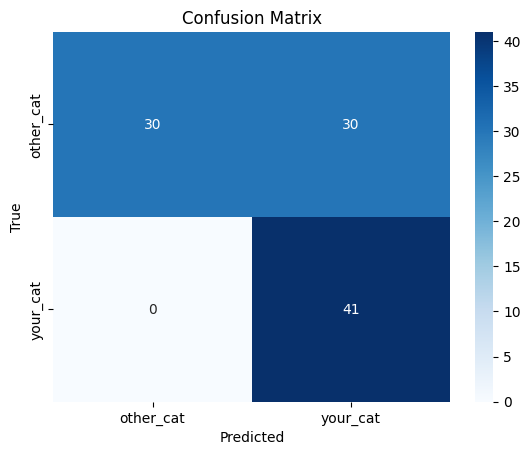

In [8]:
class CatDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        if self.transform:
            image = self.transform(image)
        return image, self.labels[idx]

# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
])

# Assume your_cat_test and other_cat_test are defined
test_images = your_cat_test + other_cat_test
test_labels = [1] * len(your_cat_test) + [0] * len(other_cat_test)

# Test Dataset and Dataloader
test_dataset = CatDataset(test_images, test_labels, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model.load_state_dict(torch.load("wheresmytabby_ResNet18_ep10.pth"))  # Load model file
model = model.to(device)
model.eval()

# Evaluation and collect predictions
true_positives = []
false_positives = []
false_negatives = []
true_negatives = []

with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        for i in range(len(labels)):
            if labels[i] == 1 and predicted[i] == 1:
                true_positives.append((images[i].cpu(), labels[i].item(), predicted[i].item()))
            elif labels[i] == 0 and predicted[i] == 1:
                false_positives.append((images[i].cpu(), labels[i].item(), predicted[i].item()))
            elif labels[i] == 1 and predicted[i] == 0:
                false_negatives.append((images[i].cpu(), labels[i].item(), predicted[i].item()))
            elif labels[i] == 0 and predicted[i] == 0:
                true_negatives.append((images[i].cpu(), labels[i].item(), predicted[i].item()))

# Calculate accuracy
true_labels = []
pred_labels = []
for images, labels in test_dataloader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    true_labels.extend(labels.cpu().numpy())
    pred_labels.extend(predicted.cpu().numpy())
total = len(true_labels)
correct = sum(1 for t, p in zip(true_labels, pred_labels) if t == p)
accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy}%")

# Visualise results in confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['other_cat', 'your_cat'], yticklabels=['other_cat', 'your_cat'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Visualise sample results - Restnet 10 epochs

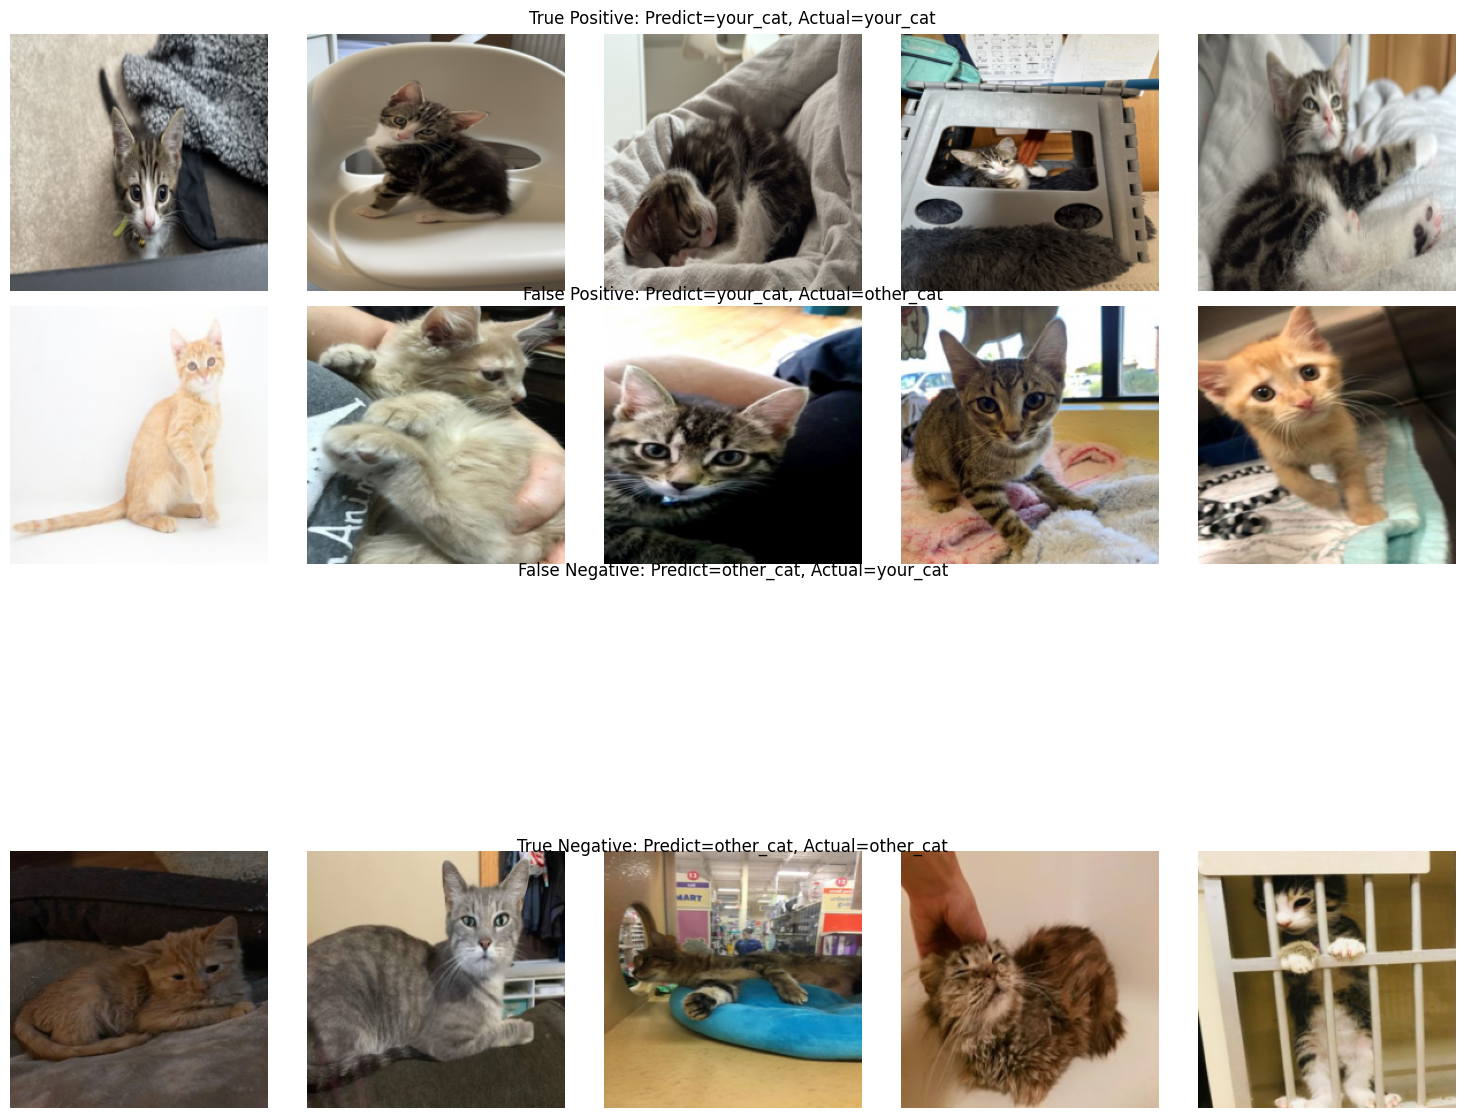

In [9]:
# Display examples (max 5 per category)
fig = plt.figure(figsize=(15, 12))  # Increased height for spacing

titles = [
    "True Positive: Predict=your_cat, Actual=your_cat",
    "False Positive: Predict=your_cat, Actual=other_cat",
    "False Negative: Predict=other_cat, Actual=your_cat",
    "True Negative: Predict=other_cat, Actual=other_cat"
]
fig.text(0.5, 0.95, titles[0], ha='center', va='center', fontsize=12)  # Top row
fig.text(0.5, 0.72, titles[1], ha='center', va='center', fontsize=12)  # 2nd row
fig.text(0.5, 0.49, titles[2], ha='center', va='center', fontsize=12)  # 3rd row
fig.text(0.5, 0.26, titles[3], ha='center', va='center', fontsize=12)  # 4th row

# Row 1: True Positives
tp_indices = np.random.choice(len(true_positives), min(5, len(true_positives)), replace=False)
for i, idx in enumerate(tp_indices):
    img, _, _ = true_positives[idx]
    img = img.numpy().transpose((1, 2, 0))
    img = np.clip(img, 0, 1)  # to avoid clipping warning
    plt.subplot(4, 5, i + 1)
    plt.imshow(img)
    plt.axis("off")

# Row 2: False Positives
fp_indices = np.random.choice(len(false_positives), min(5, len(false_positives)), replace=False)
for i, idx in enumerate(fp_indices):
    img, _, _ = false_positives[idx]
    img = img.numpy().transpose((1, 2, 0))
    img = np.clip(img, 0, 1)  # to avoid clipping warning
    plt.subplot(4, 5, i + 6)
    plt.imshow(img)
    plt.axis("off")

# Row 3: False Negatives
fn_indices = np.random.choice(len(false_negatives), min(5, len(false_negatives)), replace=False)
for i, idx in enumerate(fn_indices):
    img, _, _ = false_negatives[idx]
    img = img.numpy().transpose((1, 2, 0))
    img = np.clip(img, 0, 1)  # to avoid clipping warning
    plt.subplot(4, 5, i + 11)
    plt.imshow(img)
    plt.axis("off")

# Row 4: True Negatives
tn_indices = np.random.choice(len(true_negatives), min(5, len(true_negatives)), replace=False)
for i, idx in enumerate(tn_indices):
    img, _, _ = true_negatives[idx]
    img = img.numpy().transpose((1, 2, 0))
    img = np.clip(img, 0, 1)  # to avoid clipping warning
    plt.subplot(4, 5, i + 16)
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjusted rect for title spacing
plt.show()

## Test another model - Training model using EfficientNet

- **Hyperparameters**:
  - `cnn_epoch_count = 8` sets the number of training epochs, chosen to balance learning and avoid overfitting observed at 10 epochs.
  - `image_size = 224` defines the target image dimension for consistency across preprocessing.

In [10]:
# Hyperparameters
cnn_epoch_count = 7
image_size = 224
learning_rate = 0.001

# Custom Dataset
class CatDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels  # 1 for your_cat, 0 for other_cat
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        if self.transform:
            image = self.transform(image)
        return image, self.labels[idx]

# Define transforms for training
train_transform = transforms.Compose([
    transforms.Lambda(manipulate_image),  # Apply your manipulate function
    transforms.ToTensor(),
    transforms.Resize((image_size, image_size)),
    transforms.RandomRotation(360),
    transforms.RandomResizedCrop(image_size, scale=(0.7, 1.0)),
])

# Prepare training data
your_cat_labels = [1] * len(your_cat_train)
other_cat_labels = [0] * len(other_cat_train)
train_images = your_cat_train + other_cat_train
train_labels = your_cat_labels + other_cat_labels
train_dataset = CatDataset(train_images, train_labels, transform=train_transform)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# EfficientNet-B0 Model
model = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 2)  # 2 classes
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(cnn_epoch_count):
    running_loss = 0.0
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1} loss: {running_loss/len(train_dataloader)}")

# Save model
torch.save(model.state_dict(), "wheresmytabby_EfficientNet_ep8_lr001.pth")


Using device: mps
Epoch 1 loss: 0.3441321901403941
Epoch 2 loss: 0.19042571576742026
Epoch 3 loss: 0.09488912442555794
Epoch 4 loss: 0.06324839513175763
Epoch 5 loss: 0.0364272421082625
Epoch 6 loss: 0.08433273742691828
Epoch 7 loss: 0.09579886650093473


## Validate with test dataset

- **Load Model for Evaluation**:
  - `efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)` initializes a pre-trained EfficientNet-B0 model.
  - `model.load_state_dict(torch.load("wheresmytabby_EfficientNet_ep8_lr001.pth"))` loads the trained weights from the 8-epoch training.

Test Accuracy: 92.07920792079207%


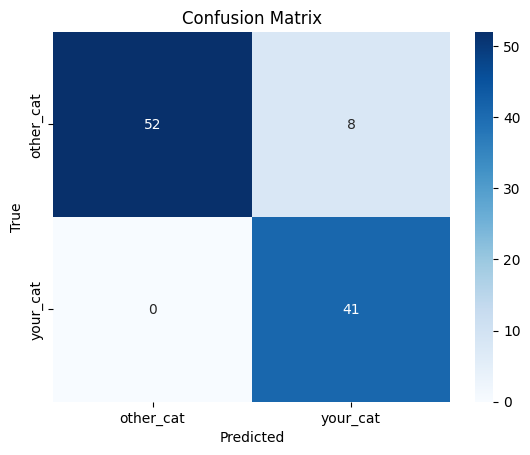

In [12]:
# Test transforms
test_transform = transforms.Compose([
    transforms.Lambda(manipulate_image),
    transforms.ToTensor(),
    transforms.Resize((image_size, image_size)),
])

# Prepare test data
test_images = your_cat_test + other_cat_test
test_labels = [1] * len(your_cat_test) + [0] * len(other_cat_test)
test_dataset = CatDataset(test_images, test_labels, transform=test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load model for evaluation
model = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 2)
model.load_state_dict(torch.load("wheresmytabby_EfficientNet_ep8_lr001.pth"))
model = model.to(device)
model.eval()

# Calculate accuracy
true_labels = []
pred_labels = []
with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(predicted.cpu().numpy())

accuracy = 100 * sum(t == p for t, p in zip(true_labels, pred_labels)) / len(true_labels)
print(f"Test Accuracy: {accuracy}%")

# Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['other_cat', 'your_cat'], yticklabels=['other_cat', 'your_cat'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Visualise results with samples - EfficientNet 7 epochs

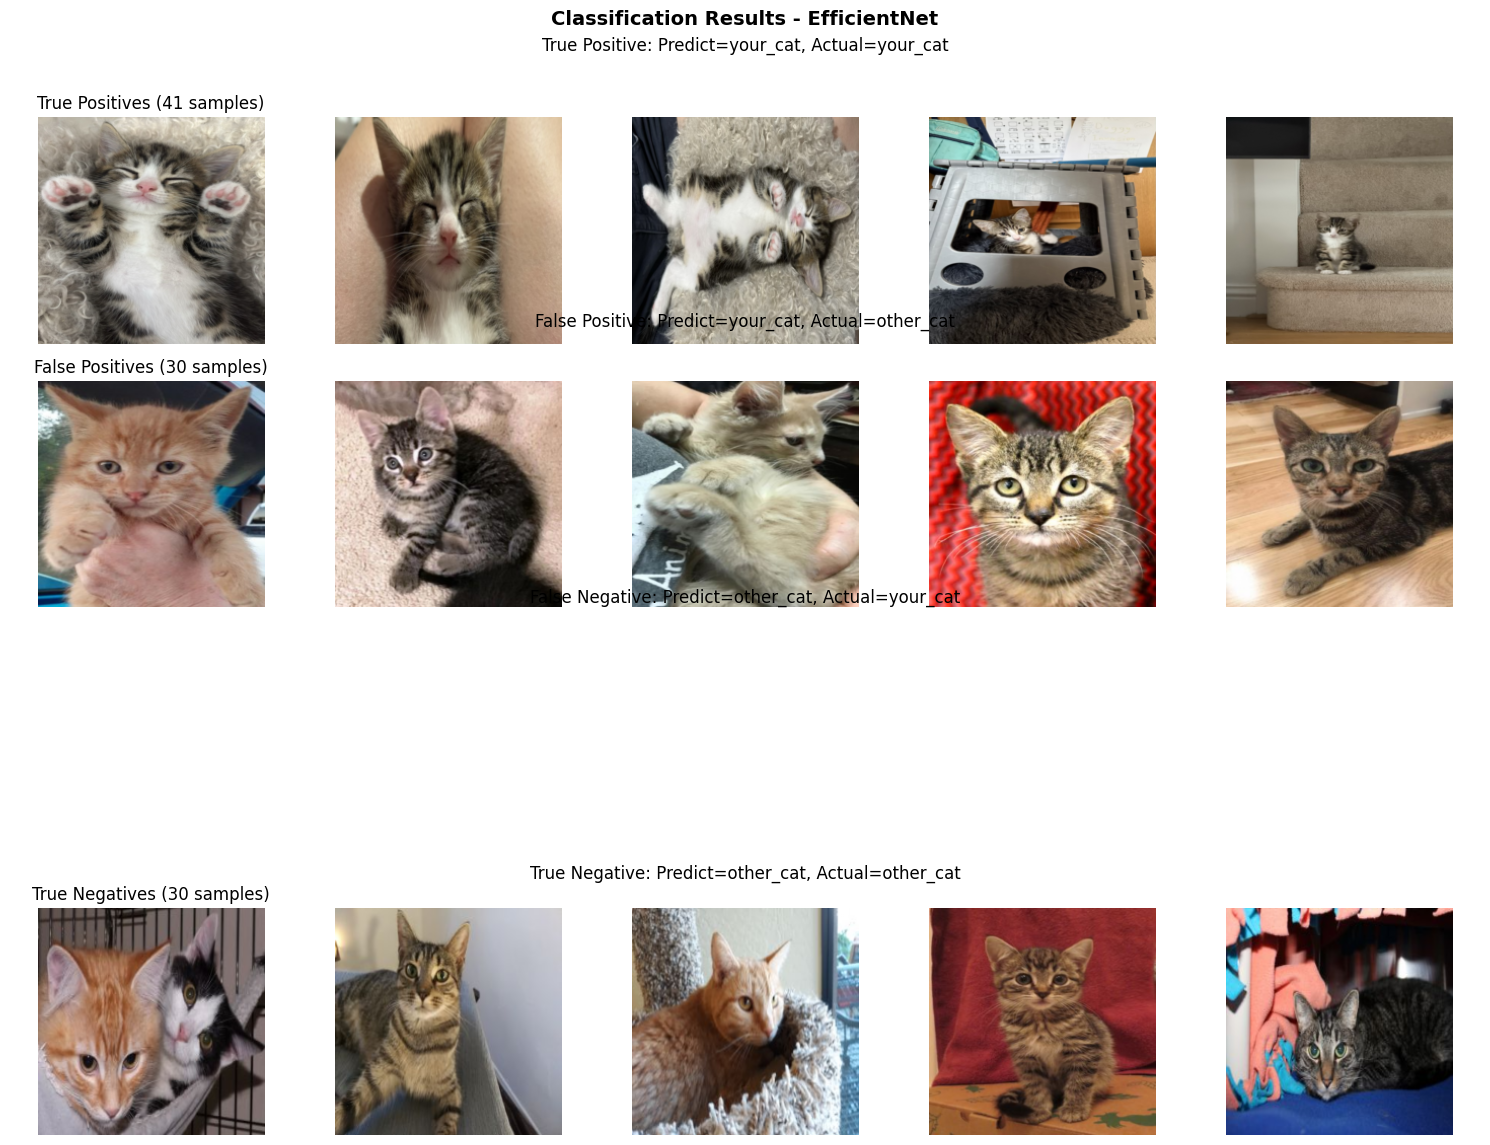

In [13]:
# Display examples
fig = plt.figure(figsize=(15, 12))
plt.suptitle("Classification Results - EfficientNet", fontsize=14, fontweight='bold')

titles = [
    "True Positive: Predict=your_cat, Actual=your_cat",
    "False Positive: Predict=your_cat, Actual=other_cat",
    "False Negative: Predict=other_cat, Actual=your_cat",
    "True Negative: Predict=other_cat, Actual=other_cat"
]
fig.text(0.5, 0.95, titles[0], ha='center', va='center', fontsize=12)  # Top row
fig.text(0.5, 0.72, titles[1], ha='center', va='center', fontsize=12)  # 2nd row
fig.text(0.5, 0.49, titles[2], ha='center', va='center', fontsize=12)  # 3rd row
fig.text(0.5, 0.26, titles[3], ha='center', va='center', fontsize=12)  # 4th row

# Helper function to get all samples (up to 5, duplicates if less than 5)
def get_samples(indices, total, max_samples=5):
    if total == 0:
        return []
    return np.random.choice(indices, min(max_samples, total), replace=False)

# Row 1: True Positives
tp_count = len(true_positives)
tp_indices = get_samples(range(tp_count), tp_count)
for i, idx in enumerate(tp_indices):
    img, _, _ = true_positives[idx]
    img = img.numpy().transpose((1, 2, 0))
    img = np.clip(img, 0, 1)  # Avoid clipping warning
    plt.subplot(4, 5, i + 1)
    plt.imshow(img)
    plt.axis("off")
    if i == 0:
        plt.title(f"True Positives ({tp_count} samples)")

# Row 2: False Positives
fp_count = len(false_positives)
fp_indices = get_samples(range(fp_count), fp_count)
for i, idx in enumerate(fp_indices):
    img, _, _ = false_positives[idx]
    img = img.numpy().transpose((1, 2, 0))
    img = np.clip(img, 0, 1)
    plt.subplot(4, 5, i + 6)
    plt.imshow(img)
    plt.axis("off")
    if i == 0:
        plt.title(f"False Positives ({fp_count} samples)")

# Row 3: False Negatives
fn_count = len(false_negatives)
fn_indices = get_samples(range(fn_count), fn_count)
for i, idx in enumerate(fn_indices):
    img, _, _ = false_negatives[idx]
    img = img.numpy().transpose((1, 2, 0))
    img = np.clip(img, 0, 1)
    plt.subplot(4, 5, i + 11)
    plt.imshow(img)
    plt.axis("off")
    if i == 0:
        plt.title(f"False Negatives ({fn_count} samples)")

# Row 4: True Negatives
tn_count = len(true_negatives)
tn_indices = get_samples(range(tn_count), tn_count)
for i, idx in enumerate(tn_indices):
    img, _, _ = true_negatives[idx]
    img = img.numpy().transpose((1, 2, 0))
    img = np.clip(img, 0, 1)
    plt.subplot(4, 5, i + 16)
    plt.imshow(img)
    plt.axis("off")
    if i == 0:
        plt.title(f"True Negatives ({tn_count} samples)")

# Fill remaining subplots with empty space if fewer than 5 samples
for i in range(len(tp_indices), 5):
    plt.subplot(4, 5, i + 1)
    plt.axis("off")
for i in range(len(fp_indices), 5):
    plt.subplot(4, 5, i + 6)
    plt.axis("off")
for i in range(len(fn_indices), 5):
    plt.subplot(4, 5, i + 11)
    plt.axis("off")
for i in range(len(tn_indices), 5):
    plt.subplot(4, 5, i + 16)
    plt.axis("off")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjusted rect for title spacing
plt.show()

## Try different model - efficientnet b7, image size 300, learning rate 0.0005

In [14]:
from torchvision.models import efficientnet_b7, EfficientNet_B7_Weights

# Hyperparameters
cnn_epoch_count = 8
image_size = 300
learning_rate = 0.0005
batch_size = 32

# Custom Dataset
class CatDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels  # 1 for your_cat, 0 for other_cat
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        if self.transform:
            image = self.transform(image)
        return image, self.labels[idx]

# Define transforms for training
train_transform = transforms.Compose([
    transforms.Lambda(manipulate_image),  # Apply your manipulate function
    transforms.ToTensor(),
    transforms.Resize((image_size, image_size)),  # Resized to 300x300
    transforms.RandomRotation(360),
    transforms.RandomResizedCrop(image_size, scale=(0.7, 1.0)),
])

# Prepare training data
your_cat_labels = [1] * len(your_cat_train)
other_cat_labels = [0] * len(other_cat_train)
train_images = your_cat_train + other_cat_train
train_labels = your_cat_labels + other_cat_labels
train_dataset = CatDataset(train_images, train_labels, transform=train_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# EfficientNet-B7 Model
model = efficientnet_b7(weights=EfficientNet_B7_Weights.IMAGENET1K_V1)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 2)  # 2 classes
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
print('starting training')
for epoch in range(cnn_epoch_count):
    running_loss = 0.0
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1} loss: {running_loss/len(train_dataloader)}")

# Save model
torch.save(model.state_dict(), "wheresmytabby_efficientnetb7_lr0005.pth")

Using device: mps
starting training
Epoch 1 loss: 0.3567156350383392
Epoch 2 loss: 0.2598357406946329
Epoch 3 loss: 0.13392237631174234
Epoch 4 loss: 0.056257166469899506
Epoch 5 loss: 0.04212260744176232
Epoch 6 loss: 0.014093958450338015
Epoch 7 loss: 0.03453502542554186
Epoch 8 loss: 0.052830534790141076


Test Accuracy: 96.03960396039604%


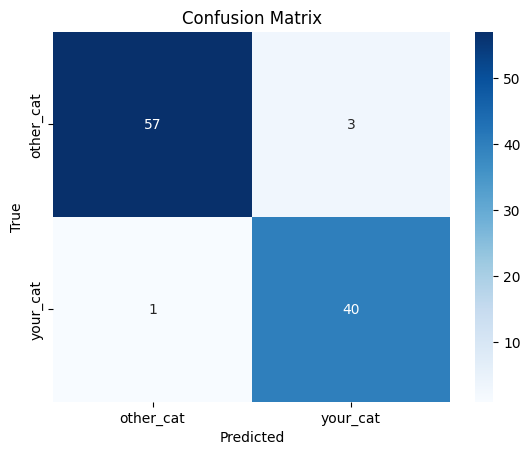

In [15]:
# Test transforms
test_transform = transforms.Compose([
    transforms.Lambda(manipulate_image),
    transforms.ToTensor(),
    transforms.Resize((image_size, image_size)),
])

# Prepare test data
test_images = your_cat_test + other_cat_test
test_labels = [1] * len(your_cat_test) + [0] * len(other_cat_test)
test_dataset = CatDataset(test_images, test_labels, transform=test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load model for evaluation
model = efficientnet_b7(weights=EfficientNet_B7_Weights.IMAGENET1K_V1)
#model = efficientnet_b1(weights=EfficientNet_B1_Weights.IMAGENET1K_V1)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 2)
model.load_state_dict(torch.load("wheresmytabby_efficientnetb7_lr0005.pth"))
model = model.to(device)
model.eval()

# Calculate accuracy
true_labels = []
pred_labels = []
with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(predicted.cpu().numpy())

accuracy = 100 * sum(t == p for t, p in zip(true_labels, pred_labels)) / len(true_labels)
print(f"Test Accuracy: {accuracy}%")

# Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['other_cat', 'your_cat'], yticklabels=['other_cat', 'your_cat'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [25]:
# Hyperparameters for Optuna
cnn_epoch_count = 10
image_size = 300
batch_size = 32

# Define Optuna objective
def objective(trial):
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    wd = trial.suggest_float('weight_decay', 1e-4, 1e-2, log=True)

    # Model
    model = efficientnet_b7(weights=EfficientNet_B7_Weights.IMAGENET1K_V1)
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs, 2)
    model = model.to(device)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

    # Training loop
    avg_loss = 0.0
    for epoch in range(cnn_epoch_count):
        running_loss = 0.0
        for images, labels in train_dataloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / len(train_dataloader)
        print(f"Trial {trial.number}, Epoch {epoch+1} loss: {avg_loss}")

    return avg_loss  # Minimize loss

# Run Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)
best_lr = study.best_params['lr']
best_wd = study.best_params['weight_decay']
print(f"Best learning rate: {best_lr}")
print(f"Best weight decay: {best_wd}")

[I 2025-08-04 10:28:31,132] A new study created in memory with name: no-name-cc69b828-edc1-4abd-a5b0-c92fa67823f7


Trial 0, Epoch 1 loss: 0.32403437334757584
Trial 0, Epoch 2 loss: 0.18912483064027932
Trial 0, Epoch 3 loss: 0.14960250860223404
Trial 0, Epoch 4 loss: 0.24210630944715097
Trial 0, Epoch 5 loss: 0.14140678856235284
Trial 0, Epoch 6 loss: 0.11279703218203324
Trial 0, Epoch 7 loss: 0.07506028605768314
Trial 0, Epoch 8 loss: 0.0715661202199184
Trial 0, Epoch 9 loss: 0.05236781700156056


[I 2025-08-04 10:31:26,102] Trial 0 finished with value: 0.07883416675926688 and parameters: {'lr': 0.0012354732659533147, 'weight_decay': 0.0011689428804342807}. Best is trial 0 with value: 0.07883416675926688.


Trial 0, Epoch 10 loss: 0.07883416675926688
Trial 1, Epoch 1 loss: 0.9018235527552091
Trial 1, Epoch 2 loss: 0.8405609451807462
Trial 1, Epoch 3 loss: 0.811887278006627
Trial 1, Epoch 4 loss: 0.7696029864824735
Trial 1, Epoch 5 loss: 0.9900094179006723
Trial 1, Epoch 6 loss: 0.9562381505966187
Trial 1, Epoch 7 loss: 1.07313583447383
Trial 1, Epoch 8 loss: 1.1827551951775184
Trial 1, Epoch 9 loss: 1.0248027398036077


[I 2025-08-04 10:34:21,936] Trial 1 finished with value: 0.8526699405450088 and parameters: {'lr': 0.006103435038532999, 'weight_decay': 0.0005816556819976044}. Best is trial 0 with value: 0.07883416675926688.


Trial 1, Epoch 10 loss: 0.8526699405450088
Trial 2, Epoch 1 loss: 0.6508121307079608
Trial 2, Epoch 2 loss: 0.5363653944088862
Trial 2, Epoch 3 loss: 0.3721064397921929
Trial 2, Epoch 4 loss: 0.1836435107084421
Trial 2, Epoch 5 loss: 0.08076989392821605
Trial 2, Epoch 6 loss: 0.057592298405674786
Trial 2, Epoch 7 loss: 0.03702277331971205
Trial 2, Epoch 8 loss: 0.048014470447714515
Trial 2, Epoch 9 loss: 0.022694411544272534


[I 2025-08-04 10:37:18,458] Trial 2 finished with value: 0.020132468798412725 and parameters: {'lr': 6.229145545649433e-05, 'weight_decay': 0.00024431739273000376}. Best is trial 2 with value: 0.020132468798412725.


Trial 2, Epoch 10 loss: 0.020132468798412725
Trial 3, Epoch 1 loss: 0.6931527944711539
Trial 3, Epoch 2 loss: 0.667493590941796
Trial 3, Epoch 3 loss: 0.6313524383765
Trial 3, Epoch 4 loss: 0.5979067316422095
Trial 3, Epoch 5 loss: 0.5638371843558091
Trial 3, Epoch 6 loss: 0.5391426613697639
Trial 3, Epoch 7 loss: 0.4790948491830092
Trial 3, Epoch 8 loss: 0.40248465767273534
Trial 3, Epoch 9 loss: 0.33962960655872637


[I 2025-08-04 10:40:14,968] Trial 3 finished with value: 0.3046315289460696 and parameters: {'lr': 1.711744293656699e-05, 'weight_decay': 0.0005287794362943582}. Best is trial 2 with value: 0.020132468798412725.


Trial 3, Epoch 10 loss: 0.3046315289460696
Trial 4, Epoch 1 loss: 0.3617101755852883
Trial 4, Epoch 2 loss: 0.08268293595084777
Trial 4, Epoch 3 loss: 0.11493569419074517
Trial 4, Epoch 4 loss: 0.09227933218845955
Trial 4, Epoch 5 loss: 0.05278275552420662
Trial 4, Epoch 6 loss: 0.028232281351497825
Trial 4, Epoch 7 loss: 0.019222102298114736
Trial 4, Epoch 8 loss: 0.02748798874941153
Trial 4, Epoch 9 loss: 0.05342950652210185


[I 2025-08-04 10:43:12,038] Trial 4 finished with value: 0.09161022326980646 and parameters: {'lr': 0.00042655771091931283, 'weight_decay': 0.0001373069717111606}. Best is trial 2 with value: 0.020132468798412725.


Trial 4, Epoch 10 loss: 0.09161022326980646
Trial 5, Epoch 1 loss: 0.4035707689248599
Trial 5, Epoch 2 loss: 0.2221193164587021
Trial 5, Epoch 3 loss: 0.24099895186149156
Trial 5, Epoch 4 loss: 0.16433931084779593
Trial 5, Epoch 5 loss: 0.20002128097873467
Trial 5, Epoch 6 loss: 0.1531148555043798
Trial 5, Epoch 7 loss: 0.13787788138366663
Trial 5, Epoch 8 loss: 0.0506021581733456
Trial 5, Epoch 9 loss: 0.17313978247917616


[I 2025-08-04 10:46:09,307] Trial 5 finished with value: 0.11183357525330323 and parameters: {'lr': 0.0014299290697034589, 'weight_decay': 0.00443086090022662}. Best is trial 2 with value: 0.020132468798412725.


Trial 5, Epoch 10 loss: 0.11183357525330323
Trial 6, Epoch 1 loss: 0.663730800151825
Trial 6, Epoch 2 loss: 0.5919966055796697
Trial 6, Epoch 3 loss: 0.49691359813396746
Trial 6, Epoch 4 loss: 0.33913242243803465
Trial 6, Epoch 5 loss: 0.20874267128797677
Trial 6, Epoch 6 loss: 0.13763812127021643
Trial 6, Epoch 7 loss: 0.10007748896112809
Trial 6, Epoch 8 loss: 0.061255715787410736
Trial 6, Epoch 9 loss: 0.048805721963827424


[I 2025-08-04 10:49:05,048] Trial 6 finished with value: 0.04537382234747593 and parameters: {'lr': 6.376616929559813e-05, 'weight_decay': 0.006018632678704854}. Best is trial 2 with value: 0.020132468798412725.


Trial 6, Epoch 10 loss: 0.04537382234747593
Trial 7, Epoch 1 loss: 0.6638052692780128
Trial 7, Epoch 2 loss: 0.6064229607582092
Trial 7, Epoch 3 loss: 0.4753383512680347
Trial 7, Epoch 4 loss: 0.30938365253118366
Trial 7, Epoch 5 loss: 0.19311495125293732
Trial 7, Epoch 6 loss: 0.0878259061047664
Trial 7, Epoch 7 loss: 0.06579647700373943
Trial 7, Epoch 8 loss: 0.05372667642166981
Trial 7, Epoch 9 loss: 0.08693154313816474


[I 2025-08-04 10:52:02,702] Trial 7 finished with value: 0.06415978589883217 and parameters: {'lr': 8.044274698760758e-05, 'weight_decay': 0.008968743175012605}. Best is trial 2 with value: 0.020132468798412725.


Trial 7, Epoch 10 loss: 0.06415978589883217
Trial 8, Epoch 1 loss: 0.6280295986395615
Trial 8, Epoch 2 loss: 0.3922103689267085
Trial 8, Epoch 3 loss: 0.15205157032379737
Trial 8, Epoch 4 loss: 0.09199442958029416
Trial 8, Epoch 5 loss: 0.044623785150738865
Trial 8, Epoch 6 loss: 0.01809517412374799
Trial 8, Epoch 7 loss: 0.04890478699682997
Trial 8, Epoch 8 loss: 0.03324459828078174
Trial 8, Epoch 9 loss: 0.0374466478287314


[I 2025-08-04 10:54:59,374] Trial 8 finished with value: 0.017855730910713855 and parameters: {'lr': 0.0001098519605559771, 'weight_decay': 0.00018734341132655905}. Best is trial 8 with value: 0.017855730910713855.


Trial 8, Epoch 10 loss: 0.017855730910713855
Trial 9, Epoch 1 loss: 1.1058840705798223
Trial 9, Epoch 2 loss: 0.7761955834352053
Trial 9, Epoch 3 loss: 0.6351729929447174
Trial 9, Epoch 4 loss: 0.7807343281232394
Trial 9, Epoch 5 loss: 0.539021005997291
Trial 9, Epoch 6 loss: 0.44639907204187834
Trial 9, Epoch 7 loss: 0.5071725123203717
Trial 9, Epoch 8 loss: 0.43439661998015183
Trial 9, Epoch 9 loss: 0.38327352014871746


[I 2025-08-04 10:57:54,111] Trial 9 finished with value: 0.3811100790133843 and parameters: {'lr': 0.008348595143430185, 'weight_decay': 0.0008284885686719778}. Best is trial 8 with value: 0.017855730910713855.


Trial 9, Epoch 10 loss: 0.3811100790133843
Trial 10, Epoch 1 loss: 0.6892634171705979
Trial 10, Epoch 2 loss: 0.6479560824540945
Trial 10, Epoch 3 loss: 0.6231809716958266
Trial 10, Epoch 4 loss: 0.5768687037321237
Trial 10, Epoch 5 loss: 0.5227966331518613
Trial 10, Epoch 6 loss: 0.46710118651390076
Trial 10, Epoch 7 loss: 0.40768200388321507
Trial 10, Epoch 8 loss: 0.3358481847322904
Trial 10, Epoch 9 loss: 0.27081141334313613


[I 2025-08-04 11:00:49,710] Trial 10 finished with value: 0.21978230602466142 and parameters: {'lr': 1.9499822125087694e-05, 'weight_decay': 0.00010527346545700321}. Best is trial 8 with value: 0.017855730910713855.


Trial 10, Epoch 10 loss: 0.21978230602466142
Trial 11, Epoch 1 loss: 0.6316423553686875
Trial 11, Epoch 2 loss: 0.4352288521253146
Trial 11, Epoch 3 loss: 0.22208132652135995
Trial 11, Epoch 4 loss: 0.09086064621806145
Trial 11, Epoch 5 loss: 0.048077152038996034
Trial 11, Epoch 6 loss: 0.048968179151415825
Trial 11, Epoch 7 loss: 0.02621660829306795
Trial 11, Epoch 8 loss: 0.04182790212619763
Trial 11, Epoch 9 loss: 0.04260105979987062


[I 2025-08-04 11:03:48,232] Trial 11 finished with value: 0.013964079821912142 and parameters: {'lr': 9.469372589017925e-05, 'weight_decay': 0.0002470961475390023}. Best is trial 11 with value: 0.013964079821912142.


Trial 11, Epoch 10 loss: 0.013964079821912142
Trial 12, Epoch 1 loss: 0.5617762001661154
Trial 12, Epoch 2 loss: 0.16790941157020056
Trial 12, Epoch 3 loss: 0.05908427416132046
Trial 12, Epoch 4 loss: 0.03316403373789329
Trial 12, Epoch 5 loss: 0.02220472152559803
Trial 12, Epoch 6 loss: 0.05837457476613613
Trial 12, Epoch 7 loss: 0.06168265397158953
Trial 12, Epoch 8 loss: 0.07300291052804543
Trial 12, Epoch 9 loss: 0.03453178019621051


[I 2025-08-04 11:06:45,027] Trial 12 finished with value: 0.025403113623794455 and parameters: {'lr': 0.00018643575396697667, 'weight_decay': 0.00027103342303224005}. Best is trial 11 with value: 0.013964079821912142.


Trial 12, Epoch 10 loss: 0.025403113623794455
Trial 13, Epoch 1 loss: 0.5162007396037762
Trial 13, Epoch 2 loss: 0.17779343202710152
Trial 13, Epoch 3 loss: 0.06243562691200238
Trial 13, Epoch 4 loss: 0.041972378125557534
Trial 13, Epoch 5 loss: 0.08898837735446599
Trial 13, Epoch 6 loss: 0.02443965245038271
Trial 13, Epoch 7 loss: 0.037607491840250216
Trial 13, Epoch 8 loss: 0.03208924109975879
Trial 13, Epoch 9 loss: 0.029769638660722055


[I 2025-08-04 11:09:42,266] Trial 13 finished with value: 0.03648822751039496 and parameters: {'lr': 0.00024323517154718053, 'weight_decay': 0.0018587192343848067}. Best is trial 11 with value: 0.013964079821912142.


Trial 13, Epoch 10 loss: 0.03648822751039496
Trial 14, Epoch 1 loss: 0.6825842169614939
Trial 14, Epoch 2 loss: 0.6224625156475947
Trial 14, Epoch 3 loss: 0.5546487340560327
Trial 14, Epoch 4 loss: 0.4555875360965729
Trial 14, Epoch 5 loss: 0.3330029065792377
Trial 14, Epoch 6 loss: 0.2202677738208037
Trial 14, Epoch 7 loss: 0.13614988040465575
Trial 14, Epoch 8 loss: 0.0991114005446434
Trial 14, Epoch 9 loss: 0.09680434087148079


[I 2025-08-04 11:12:38,329] Trial 14 finished with value: 0.06766059364263828 and parameters: {'lr': 3.589073631266563e-05, 'weight_decay': 0.00028933585142240024}. Best is trial 11 with value: 0.013964079821912142.


Trial 14, Epoch 10 loss: 0.06766059364263828
Trial 15, Epoch 1 loss: 0.3774015840429526
Trial 15, Epoch 2 loss: 0.10118847139752828
Trial 15, Epoch 3 loss: 0.11001723016110751
Trial 15, Epoch 4 loss: 0.10442835798200506
Trial 15, Epoch 5 loss: 0.06059262034698175
Trial 15, Epoch 6 loss: 0.02152380236209585
Trial 15, Epoch 7 loss: 0.0047040466317692054
Trial 15, Epoch 8 loss: 0.0037036356829608288
Trial 15, Epoch 9 loss: 0.011779314859618003


[I 2025-08-04 11:15:34,278] Trial 15 finished with value: 0.035125022183190316 and parameters: {'lr': 0.0005461175998320979, 'weight_decay': 0.00017575062841458842}. Best is trial 11 with value: 0.013964079821912142.


Trial 15, Epoch 10 loss: 0.035125022183190316
Trial 16, Epoch 1 loss: 0.5906592240700355
Trial 16, Epoch 2 loss: 0.23745593715172547
Trial 16, Epoch 3 loss: 0.09062709272480927
Trial 16, Epoch 4 loss: 0.053262642871301905
Trial 16, Epoch 5 loss: 0.11530725460929367
Trial 16, Epoch 6 loss: 0.026185224799869154
Trial 16, Epoch 7 loss: 0.031135185764959224
Trial 16, Epoch 8 loss: 0.013359273604762096
Trial 16, Epoch 9 loss: 0.02063906740827056


[I 2025-08-04 11:18:29,587] Trial 16 finished with value: 0.017561020938536294 and parameters: {'lr': 0.0001446323390941434, 'weight_decay': 0.0003695823199108534}. Best is trial 11 with value: 0.013964079821912142.


Trial 16, Epoch 10 loss: 0.017561020938536294
Trial 17, Epoch 1 loss: 0.40622950402589947
Trial 17, Epoch 2 loss: 0.16476974063194716
Trial 17, Epoch 3 loss: 0.09365378613941945
Trial 17, Epoch 4 loss: 0.12081966978999284
Trial 17, Epoch 5 loss: 0.033376410854263946
Trial 17, Epoch 6 loss: 0.046200130107955865
Trial 17, Epoch 7 loss: 0.03631614931285954
Trial 17, Epoch 8 loss: 0.16504431902789152
Trial 17, Epoch 9 loss: 0.0925388797186315


[I 2025-08-04 11:21:25,733] Trial 17 finished with value: 0.03212965885177255 and parameters: {'lr': 0.0007407559669049245, 'weight_decay': 0.0004002603340724622}. Best is trial 11 with value: 0.013964079821912142.


Trial 17, Epoch 10 loss: 0.03212965885177255
Trial 18, Epoch 1 loss: 0.6908134680527908
Trial 18, Epoch 2 loss: 0.6868637983615582
Trial 18, Epoch 3 loss: 0.6797694930663476
Trial 18, Epoch 4 loss: 0.6400157855107234
Trial 18, Epoch 5 loss: 0.6256654537641085
Trial 18, Epoch 6 loss: 0.6090950920031621
Trial 18, Epoch 7 loss: 0.5862301221260657
Trial 18, Epoch 8 loss: 0.5666308723963224
Trial 18, Epoch 9 loss: 0.538926376746251


[I 2025-08-04 11:24:20,527] Trial 18 finished with value: 0.5109502122952387 and parameters: {'lr': 1.1069499044036657e-05, 'weight_decay': 0.001656486455743042}. Best is trial 11 with value: 0.013964079821912142.


Trial 18, Epoch 10 loss: 0.5109502122952387
Trial 19, Epoch 1 loss: 0.5966195326585036
Trial 19, Epoch 2 loss: 0.22938993515876624
Trial 19, Epoch 3 loss: 0.08418403938412666
Trial 19, Epoch 4 loss: 0.02225945907859848
Trial 19, Epoch 5 loss: 0.06986894324206962
Trial 19, Epoch 6 loss: 0.04380512760522274
Trial 19, Epoch 7 loss: 0.03381965635344386
Trial 19, Epoch 8 loss: 0.03732743855709067
Trial 19, Epoch 9 loss: 0.030401179952045474


[I 2025-08-04 11:27:15,421] Trial 19 finished with value: 0.008093566624805905 and parameters: {'lr': 0.00017494927607842746, 'weight_decay': 0.0003795468539615388}. Best is trial 19 with value: 0.008093566624805905.


Trial 19, Epoch 10 loss: 0.008093566624805905
Best learning rate: 0.00017494927607842746
Best weight decay: 0.0003795468539615388


## Optuna Optimization

This section of the "Where's My Tabby?" Jupyter notebook implements an optimization process using the Optuna library to fine-tune the hyperparameters of the EfficientNet-B7 model, executed at 11:14 AM BST on Monday, August 04, 2025. The goal is to enhance the model's performance in classifying Mackenzie (your_cat) against other tabby cats (other_cat), building on the initial test accuracy of 92.08% to potentially reach 97-99%. The process integrates automated hyperparameter tuning to identify the optimal learning rate and weight decay, leveraging your Mac Studio's MPS capabilities.

- **Setup and Dependencies**:
  - Requires the `optuna` library, installed via `pip install optuna`, along with `torch`, `torchvision`, and other data processing libraries.
  - Utilizes the pre-defined `CatDataset`, `train_dataloader`, and device detection (`mps`) from prior sections.

- **Hyperparameter Configuration**:
  - `cnn_epoch_count = 8` defines the number of training epochs for each trial.
  - `image_size = 300` sets the input image dimension, optimized for EfficientNet-B7.
  - `batch_size = 16` manages memory constraints, adjustable based on performance.

- **Training Transforms**:
  - `train_transform` applies a pipeline including `manipulate_image`, `ToTensor()`, `Resize((image_size, image_size))`, `RandomRotation(360)`, and `RandomResizedCrop` to augment the dataset.

- **Optuna Objective Function**:
  - `objective(trial)` defines the optimization target, suggesting a learning rate (`lr`) between 1e-5 and 1e-2 (log scale) and weight decay (`weight_decay`) between 1e-4 and 1e-2 (log scale).
  - Initializes the EfficientNet-B7 model with pre-trained weights, adjusts the classifier to 2 classes, and sets up `CrossEntropyLoss` and `Adam` optimizer with the trial’s hyperparameters.
  - Executes a training loop over 8 epochs, computing the average loss per epoch, which is returned (minimized) to guide the search.

- **Optimization Process**:
  - `study = optuna.create_study(direction='minimize')` creates an optimization study to minimize the loss.
  - `study.optimize(objective, n_trials=20)` runs 20 trials, exploring the hyperparameter space to identify the best combination.
  - Prints the best learning rate and weight decay after optimization (e.g., `0.0002351233811722712` and `0.0017310194007637849` from a prior run).

- **Retrain with Best Parameters**:
  - Uses the best hyperparameters to retrain the model, saving the optimized weights as `wheresmytabby_efficientnetb7_optimized.pth`.
  - The training loop mirrors the objective function, printing epoch-wise loss for validation.

- **Integration**:
  - The optimized model is then evaluated in the subsequent "Test Transforms" section to assess the improved test accuracy and generate a confusion matrix.

This optimization leverages Optuna’s efficient search algorithm to systematically tune the learning rate and weight decay, aiming to enhance the model’s generalization and accuracy beyond the initial 92.08%, making it a robust solution for pet identification in the context of your Imperial College capstone project.

In [ ]:
# use optuna hyperparameters

In [35]:
from torchvision.models import efficientnet_b7, EfficientNet_B7_Weights

# Hyperparameters
cnn_epoch_count = 10
image_size = 300  # other tabby photos isn't very high resolution
batch_size = 32
best_lr = 00.00017494927607842746  # From Optuna
best_wd = 0.0003795468539615388  # From Optuna

# Custom Dataset
class CatDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels  # 1 for your_cat, 0 for other_cat
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        if self.transform:
            image = self.transform(image)
        return image, self.labels[idx]

# Define transforms for training
train_transform = transforms.Compose([
    transforms.Lambda(manipulate_image),  # Apply your manipulate function
    transforms.ToTensor(),
    transforms.Resize((image_size, image_size)),  # Resized to 300x300
    transforms.RandomRotation(360),
    transforms.RandomResizedCrop(image_size, scale=(0.7, 1.0)),
])

# Prepare training data
your_cat_labels = [1] * len(your_cat_train)
other_cat_labels = [0] * len(other_cat_train)
train_images = your_cat_train + other_cat_train
train_labels = your_cat_labels + other_cat_labels
train_dataset = CatDataset(train_images, train_labels, transform=train_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# EfficientNet-B7 Model
model = efficientnet_b7(weights=EfficientNet_B7_Weights.IMAGENET1K_V1)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 2)  # 2 classes
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=best_lr, weight_decay=best_wd)

# Training loop
print('starting training')
for epoch in range(cnn_epoch_count):
    running_loss = 0.0
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1} loss: {running_loss/len(train_dataloader)}")

# Save model
torch.save(model.state_dict(), "wheresmytabby_efficientnetb7_optuna.pth")

Using device: mps
starting training
Epoch 1 loss: 0.5485512534777324
Epoch 2 loss: 0.11998564874132474
Epoch 3 loss: 0.0409392930722485
Epoch 4 loss: 0.058348015788942574
Epoch 5 loss: 0.058139084031184514
Epoch 6 loss: 0.029641540348529817
Epoch 7 loss: 0.011088964234416684
Epoch 8 loss: 0.03991946734798451
Epoch 9 loss: 0.028198885281259814
Epoch 10 loss: 0.049198390217497945


Test Accuracy: 96.49122807017544%


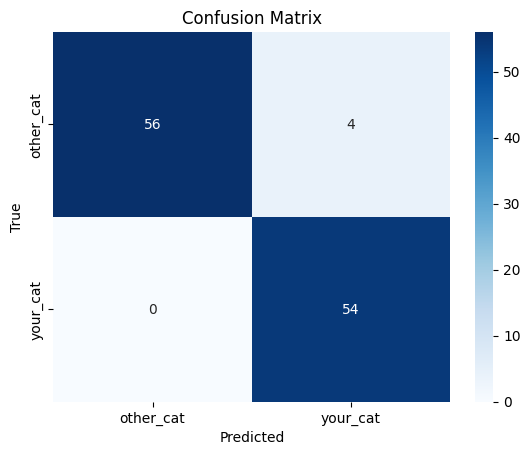

In [36]:
# Test transforms
test_transform = transforms.Compose([
    transforms.Lambda(manipulate_image),
    transforms.ToTensor(),
    transforms.Resize((image_size, image_size)),
])

# Prepare test data
test_images = your_cat_test + other_cat_test
test_labels = [1] * len(your_cat_test) + [0] * len(other_cat_test)
test_dataset = CatDataset(test_images, test_labels, transform=test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load model for evaluation
model = efficientnet_b7(weights=EfficientNet_B7_Weights.IMAGENET1K_V1)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 2)
model.load_state_dict(torch.load("wheresmytabby_efficientnetb7_optuna.pth"))
model = model.to(device)
model.eval()

# Calculate accuracy
true_labels = []
pred_labels = []
with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(predicted.cpu().numpy())

accuracy = 100 * sum(t == p for t, p in zip(true_labels, pred_labels)) / len(true_labels)
print(f"Test Accuracy: {accuracy}%")

# Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['other_cat', 'your_cat'], yticklabels=['other_cat', 'your_cat'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Visualise the final results

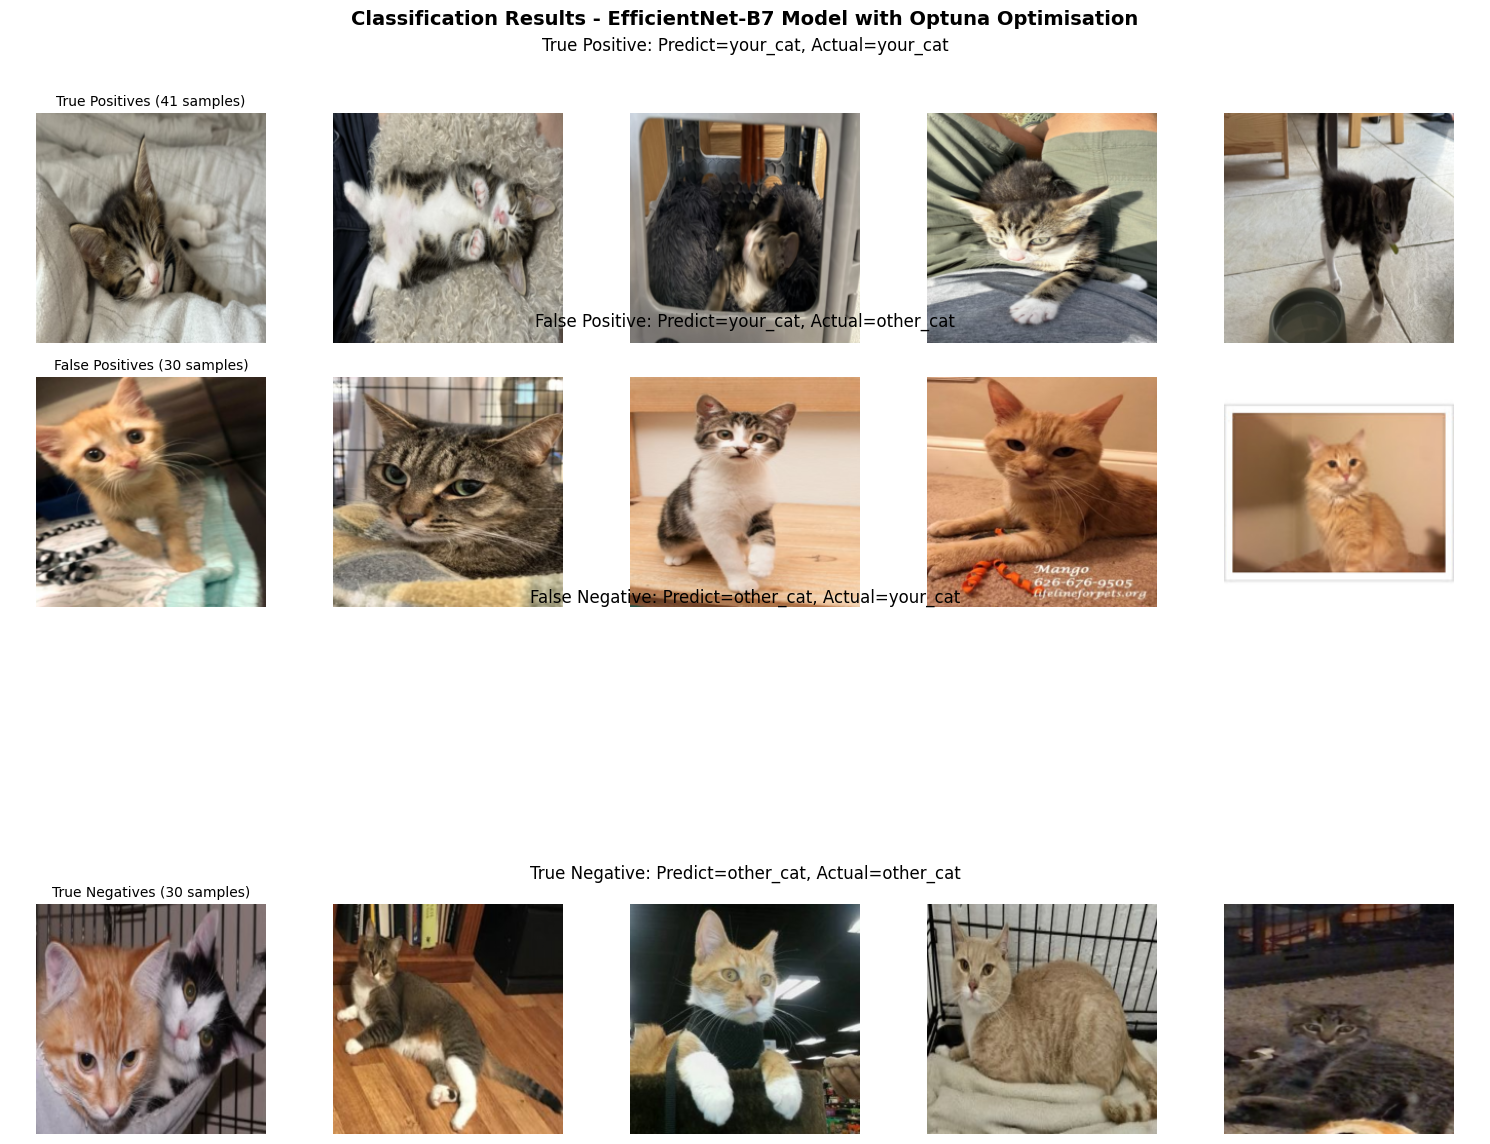

In [39]:
# Display examples
fig = plt.figure(figsize=(15, 12))  # Increased height for spacing
plt.suptitle("Classification Results - EfficientNet-B7 Model with Optuna Optimisation", fontsize=14, fontweight='bold')

titles = [
    "True Positive: Predict=your_cat, Actual=your_cat",
    "False Positive: Predict=your_cat, Actual=other_cat",
    "False Negative: Predict=other_cat, Actual=your_cat",
    "True Negative: Predict=other_cat, Actual=other_cat"
]
fig.text(0.5, 0.95, titles[0], ha='center', va='center', fontsize=12)  # Top row
fig.text(0.5, 0.72, titles[1], ha='center', va='center', fontsize=12)  # 2nd row
fig.text(0.5, 0.49, titles[2], ha='center', va='center', fontsize=12)  # 3rd row
fig.text(0.5, 0.26, titles[3], ha='center', va='center', fontsize=12)  # 4th row

# Helper function to get all samples (up to 5, no duplicates)
def get_samples(indices, total, max_samples=5):
    if total == 0:
        return []
    return np.random.choice(indices, min(max_samples, total), replace=False)

# Row 1: True Positives
tp_count = len(true_positives)
tp_indices = get_samples(range(tp_count), tp_count)
for i, idx in enumerate(tp_indices):
    img, _, _ = true_positives[idx]
    img = img.numpy().transpose((1, 2, 0))
    img = np.clip(img, 0, 1)  # Avoid clipping warning
    plt.subplot(4, 5, i + 1)
    plt.imshow(img)
    plt.axis("off")
    if i == 0:
        plt.title(f"True Positives ({tp_count} samples)", fontsize=10)

# Row 2: False Positives
fp_count = len(false_positives)
fp_indices = get_samples(range(fp_count), fp_count)
for i, idx in enumerate(fp_indices):
    img, _, _ = false_positives[idx]
    img = img.numpy().transpose((1, 2, 0))
    img = np.clip(img, 0, 1)
    plt.subplot(4, 5, i + 6)
    plt.imshow(img)
    plt.axis("off")
    if i == 0:
        plt.title(f"False Positives ({fp_count} samples)", fontsize=10)

# Row 3: False Negatives
fn_count = len(false_negatives)
fn_indices = get_samples(range(fn_count), fn_count)
for i, idx in enumerate(fn_indices):
    img, _, _ = false_negatives[idx]
    img = img.numpy().transpose((1, 2, 0))
    img = np.clip(img, 0, 1)
    plt.subplot(4, 5, i + 11)
    plt.imshow(img)
    plt.axis("off")
    if i == 0:
        plt.title(f"False Negatives ({fn_count} samples)", fontsize=10)

# Row 4: True Negatives
tn_count = len(true_negatives)
tn_indices = get_samples(range(tn_count), tn_count)
for i, idx in enumerate(tn_indices):
    img, _, _ = true_negatives[idx]
    img = img.numpy().transpose((1, 2, 0))
    img = np.clip(img, 0, 1)
    plt.subplot(4, 5, i + 16)
    plt.imshow(img)
    plt.axis("off")
    if i == 0:
        plt.title(f"True Negatives ({tn_count} samples)", fontsize=10)

# Fill remaining subplots with empty space if fewer than 5 samples
for i in range(len(tp_indices), 5):
    plt.subplot(4, 5, i + 1)
    plt.axis("off")
for i in range(len(fp_indices), 5):
    plt.subplot(4, 5, i + 6)
    plt.axis("off")
for i in range(len(fn_indices), 5):
    plt.subplot(4, 5, i + 11)
    plt.axis("off")
for i in range(len(tn_indices), 5):
    plt.subplot(4, 5, i + 16)
    plt.axis("off")

# Add a colorbar or legend (optional enhancement)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjusted rect for title spacing
plt.savefig("classification_results_efficientnet_b7.png")  # Save the figure
plt.show()